## Get sample data ready

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
import time
from datetime import datetime, date, timedelta
import folium
import os
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.insert(0, '/home/stang/user-profile/stats-spark')
from utils import load_header_config
from veh_stats import get_charged_stats
import geocoder
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:85% !important; }</style>"))

In [7]:
d = 20171201
header, configs = load_header_config('aglog_header.csv')
df = pd.read_csv('ag_{}.csv'.format(d), header=None, names=header, index_col=False)
print(df.shape)
df.dropna(subset=['LAT84', 'LON84', 'CCS_CHARGEVOLT', 'CCS_CHARGECUR'], inplace=True)
print(df.shape)
df = df[df['CCS_CHARGECUR'] > 0]
print(df.shape)

df['TDATE'] = pd.to_datetime(df['TDATE'], unit='ms', utc=True).dt.tz_convert('Asia/Hong_Kong')
df.sort_values(by=['VIN', 'TDATE'], inplace=True)

# drop time duplicate
df['TDELTA'] = df['TDATE'].diff().fillna(timedelta(seconds=10))
df['TDELTA'] = df['TDELTA'].apply(lambda x: x.seconds)
df = df[df['TDELTA'] > 5]
print(df.shape)

# drop LON and LAT duplicate
df.drop_duplicates(subset=['LAT84', 'LON84'], inplace=True)
print(df.shape)

df.reset_index(drop=True, inplace=True)
cols = ['VIN', 'TDATE', 'CCS_CHARGEVOLT', 'CCS_CHARGECUR', 'LON84', 'LAT84']
df = df[cols]
vins = df['VIN'].unique().tolist()
df1 = df

(673538, 85)
(168689, 85)
(123635, 85)
(123296, 86)
(93079, 86)


In [4]:
df.head()

,VIN,TDATE,CCS_CHARGEVOLT,CCS_CHARGECUR,LON84,LAT84
0,LMGGN1S50F1000625,2017-12-01 07:48:03+08:00,339.8,5.8,113.492433,23.043819
1,LMGGN1S50F1000625,2017-12-01 07:48:13+08:00,339.4,5.8,113.492438,23.043830
2,LMGGN1S50F1000625,2017-12-01 07:48:33+08:00,340.1,5.8,113.492433,23.043822
3,LMGGN1S50F1000625,2017-12-01 07:48:43+08:00,340.0,5.8,113.492433,23.043816
4,LMGGN1S50F1000625,2017-12-01 07:48:53+08:00,339.9,5.8,113.492430,23.043816


In [5]:
location = geocoder.google([23.043819, 113.492433], method='reverse')

In [8]:
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
great_circle(newport_ri, cleveland_oh).km

864.4567616296598

## Geocoding tools

For geocoding and reverse geocoding, existing popular python modules are [geocoder](https://github.com/DenisCarriere/geocoder), [reverse-geocoder](https://github.com/thampiman/reverse-geocoder), [geopy](https://github.com/geopy/geopy), etc. Only geocoder is still well maintained up-to-date at Github.

geocoder provides mutiple map services to do geocoding, each with country/region, usage, erverse limitation. Given that we want reverse geocoding tool in China, preferably no rate limit, since we are going to do reverse geocoding in batch. Gaode, Baidu, Google, ArcGIS, and Komoot can serve that purpose for us.

Among them, 
0. Both **Gaode** and **Baidu** requires an API key, which requires user has a China cell phone number
1. **Google** returns the finest level of information, but it has a rate limit, sometimes it returns None, so we have to do error handling and auto-retry mechanism. 
2. **Komoot** has no rate limit, but it returns location up to city level (no sublocality or street info)
3. **ArcGIS** is similar with Komoot (no sublocality info), and also the results are in Chinese, which could cause a problem processing these strings.

In [2]:
import geocoder

In [7]:
%%time
key='0716e5809437f14e3dd0793a5c6d2b13'
g = geocoder.gaode([23.101288, 113.367541], method='reverse', key=key)
print(g.address)
print(g.country)
print(g.state)
print(g.city)
print(g.district)
print(g.street)
print(g.adcode)

广东省广州市海珠区琶洲街道会展东路广州国际会展中心
中国
广东省
广州市
海珠区
会展东路
440105
CPU times: user 5.96 ms, sys: 2.81 ms, total: 8.77 ms
Wall time: 437 ms


In [17]:
%%time
g = geocoder.google([23.101288, 113.367541], method='reverse')
print(g.address)
print(g.country)
print(g.state)
print(g.city)
print(g.sublocality)
print(g.street)
print(g.postal)

China, Guangdong Sheng, Guangzhou Shi, Haizhu Qu, Hui Zhan Dong Lu, 1号琶洲香格里拉大酒店内
CN
Guangdong Sheng
Guangzhou Shi
Haizhu Qu
Hui Zhan Dong Lu
None
CPU times: user 24.8 ms, sys: 1.53 ms, total: 26.3 ms
Wall time: 161 ms


In [22]:
%%time
g = geocoder.komoot([23.101288, 113.367541], method='reverse')
print(g.address)
print(g.country) 
print(g.state) 
print(g.city)
print(g.street)

Guangzhou Guangdong, China
China
Guangdong
Guangzhou

CPU times: user 23.9 ms, sys: 989 µs, total: 24.8 ms
Wall time: 695 ms


In [24]:
%%time
g = geocoder.arcgis([23.101288, 113.367541], method='reverse')
print(g.address)
print(g.country)
print(g.state)
print(g.city)
print(g.street)

广东省广州市海珠区会展东路
CHN
广东省
广州市

CPU times: user 25.5 ms, sys: 2.16 ms, total: 27.7 ms
Wall time: 1.57 s


Speed test:
1. Google geocoder has lots of none values (limit for standard user is 2500 free calls per day), although it is fast.
2. Komoot is about 3 times slower than Google, but the result is complete. 0.7s per row
3. ArcGIS is slowest (7 times slower than Google), maybe because of the Chinese characters

Naive approach:
1. google's paid plan is $0.5 per 1K requests, we have more than 3.5 billion rows, which would cost 1.75 million dollars
2. it also has a 100K requests daily cap, which would take about 95 years to process all the records
3. is using komoot, which process reverse geocoding at 0.7s per row (although no rate limit), meaning it would take about 70+ years to finish 3.5 billion records.

To reduce number of requests:
4. But considering most of the coordinates are close, and we only want the information at city level. So if we can find out the bounding box for each city, and also manage to find out whether a coordinate is within the box, then we saved lots of geocoding requests.
5. Another approach is we know that there are only limited number of charging stations in a city, so we can first filter out charging records, then do a clustering based on coordinates, only look up address info for centers of cluster.

## caching charging station locations

In [8]:
header, configs = load_header_config('aglog_header.csv')
cols = ['LON84', 'LAT84']
def get_df(d):
    lonlat_file = 'lonlat_on_charging/lonlat_on_charging_{}.csv'.format(d)
    if os.path.exists(lonlat_file):
        return pd.read_csv(lonlat_file)
    
    df = pd.read_csv('ag_{}.csv'.format(d), header=None, names=header, index_col=False)
    df.dropna(subset=['LAT84', 'LON84', 'CCS_CHARGEVOLT', 'CCS_CHARGECUR'], inplace=True)
    df = df[df['CCS_CHARGECUR'] > 0]
    
    df.sort_values(by=['VIN', 'TDATE'], inplace=True)
    df['TDATE'] = pd.to_datetime(df['TDATE'], unit='ms', utc=True).dt.tz_convert('Asia/Hong_Kong')
    df['TDELTA'] = df['TDATE'].diff().fillna(timedelta(seconds=10))
    df['TDELTA'] = df['TDELTA'].apply(lambda x: x.seconds)
    df = df[(df['TDELTA'] > 5) | (df['TDELTA'] < 0)]
    
    df = df[cols]
    df.to_csv(lonlat_file, index=False)
    return df

In [9]:
df = pd.DataFrame()
start_date = date(2018, 1, 31)
n = 31
for single_date in (start_date - timedelta(n) for n in range(n)):
    d = single_date.strftime("%Y%m%d")
    df = pd.concat([df, get_df(d)])
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [10]:
df.shape

(11647585, 2)

In [11]:
df_copy = df

________

In [12]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [13]:
df.head()

,LON84,LAT84
0,113.483244,23.055041
1,113.483247,23.055038
2,113.483247,23.055041
3,113.483238,23.055050
4,113.483241,23.055047


In [14]:
df = df_copy.iloc[:1000, :]

In [15]:
df.head()

,LON84,LAT84
0,113.483244,23.055041
1,113.483247,23.055038
2,113.483247,23.055041
3,113.483238,23.055050
4,113.483241,23.055047


In [16]:
df.loc[:, 'lon'] = df.loc[:, 'LON84'].apply(lambda x: float(truncate(x, 5)))
df.loc[:, 'lat'] = df.loc[:, 'LAT84'].apply(lambda x: float(truncate(x, 5)))
df = df[['lon', 'lat']].copy()
df.drop_duplicates(inplace=True)

/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/lib64/python2.7/site-packages/pandas/core/indexing.py:621: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [17]:
df.shape

(363, 2)

In [18]:
df.head()

,lon,lat
0,113.48324,23.05504
1,113.48324,23.05503
3,113.48323,23.05505
9,113.48324,23.05506
10,113.48321,23.05504


In [19]:
coords = df.as_matrix()

In [20]:
meters_per_radian = 6371.0088 * 1000
epsilon = 20 / meters_per_radian # use 10 meters to be considered as a cluser
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', 
            metric='haversine', n_jobs=-1).fit(np.radians(coords))

In [21]:
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))
df['cluster'] = cluster_labels

Number of clusters: 4


In [22]:
clusters_copy = clusters

In [23]:
def get_centroid(cluster):
    p = MultiPoint(cluster)
    return p.centroid.x, p.centroid.y
centroids = clusters.map(get_centroid)
centroids_backup = centroids

____

In [24]:
clusters[1]

array([[113.27038,  23.13552],
       [113.27038,  23.13553],
       [113.27038,  23.13554],
       [113.27037,  23.13553],
       [113.27036,  23.13553],
       [113.27035,  23.13552],
       [113.27035,  23.13553]])

In [25]:
a = clusters[1][0]
b = clusters[1][6]
great_circle(a, b).m

3.3655970613725232

In [26]:
lons, lats = zip(*centroids_backup)
centroids = pd.DataFrame({'lon':lons, 'lat':lats})
centroids.iloc[1, :]

lat     23.135529
lon    113.270367
Name: 1, dtype: float64

In [254]:
great_circle((23.135529, 113.270367), (23.13552, 113.269)).m

305.67241848329434

In [255]:
great_circle((23.136, 113.27), (23.133, 113.273)).m

453.3166634783701

In [256]:
np.radians([23.136])

array([0.40379938])

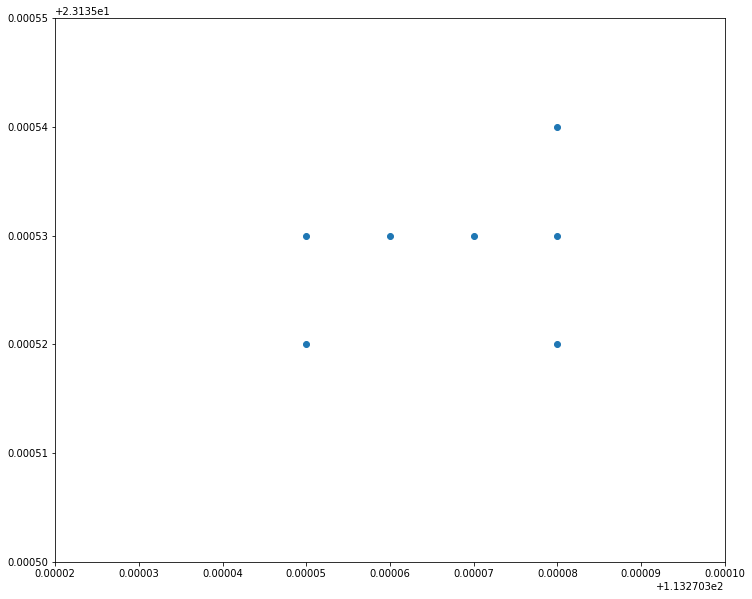

In [27]:
lons, lats = zip(*clusters[1])
temp = pd.DataFrame({'lat': lats, 'lon': lons})
fig, ax = plt.subplots(figsize=[12, 10])
ax.scatter(temp['lon'], temp['lat'])
ax.scatter(113.27119, 23.13413, c='r')
# circle = plt.Circle((113.270367, 23.135529), 0.002, color='green', fill=False)
# ax.add_artist(circle)
plt.xlim(113.27032, 113.27040)
plt.ylim(23.135500, 23.135550)
plt.show()

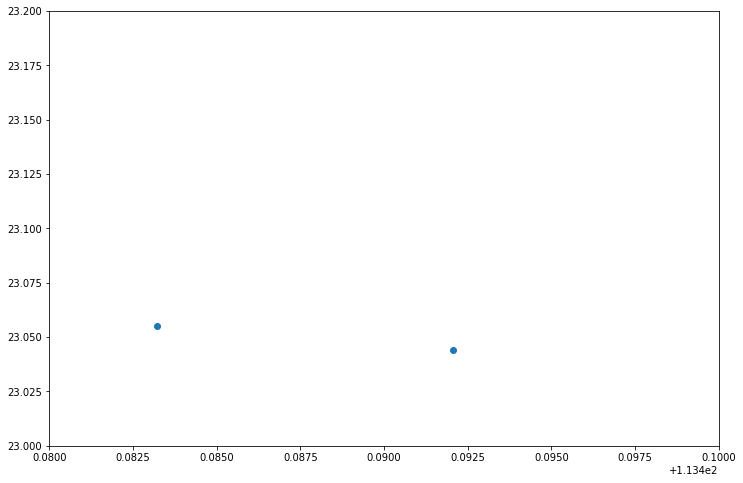

In [28]:
fig, ax = plt.subplots(figsize=[12, 8])
ax.scatter(centroids['lon'], centroids['lat'])
plt.xlim(113.48, 113.5)
plt.ylim(23, 23.2)
plt.show()

In [29]:
i = 1
p = max(clusters[i], key=lambda point: great_circle(point, centroids_backup[i]).m)
great_circle(p, centroids_backup[i]).m

1.9435803687200175

In [30]:
lons, lats = zip(*centroids_backup)
centroids = pd.DataFrame({'lon':lons, 'lat':lats})

In [31]:
centroids.head()

,lat,lon
0,23.055051,113.483222
1,23.135529,113.270367
2,30.240952,120.171192
3,23.044017,113.492070


In [32]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

In [206]:
centroids.sort_values(by=['lon', 'lat']).head()

,lat,lon
1714,39.429315,75.902261
1716,39.429270,75.902616
2014,39.425670,75.902866
6300,39.425340,75.903572
4020,39.427960,75.903894


In [207]:
centroids.shape

(7697, 2)

In [208]:
centroids.loc[:, 'lat'] = centroids.loc[:, 'lat'].apply(lambda x: float(truncate(x, 5)))
centroids.loc[:, 'lon'] = centroids.loc[:, 'lon'].apply(lambda x: float(truncate(x, 5)))
centroids = centroids[['lon', 'lat']].copy()
centroids.drop_duplicates(inplace=True)
centroids.shape

(7697, 2)

In [209]:
centroids.head()

,lon,lat
0,113.48314,23.05509
1,113.27119,23.13413
2,120.17119,30.24095
3,113.49234,23.04395
4,113.34049,23.14892


In [210]:
centroids.sort_values(by=['lon', 'lat']).head()

,lon,lat
1714,75.90226,39.42931
1716,75.90261,39.42927
2014,75.90286,39.42567
6300,75.90357,39.42534
4020,75.90389,39.42796


## Clustering charging stations

In [33]:
df = df1
print(df.shape)
df.head()

(93079, 6)


,VIN,TDATE,CCS_CHARGEVOLT,CCS_CHARGECUR,LON84,LAT84
0,LMGGN1S50F1000625,2017-12-01 07:48:03+08:00,339.8,5.8,113.492433,23.043819
1,LMGGN1S50F1000625,2017-12-01 07:48:13+08:00,339.4,5.8,113.492438,23.043830
2,LMGGN1S50F1000625,2017-12-01 07:48:33+08:00,340.1,5.8,113.492433,23.043822
3,LMGGN1S50F1000625,2017-12-01 07:48:43+08:00,340.0,5.8,113.492433,23.043816
4,LMGGN1S50F1000625,2017-12-01 07:48:53+08:00,339.9,5.8,113.492430,23.043816


In [34]:
%%time
coords = df.as_matrix(columns=['LAT84', 'LON84'])

meters_per_radian = 6371.0088 * 1000
epsilon = 20 / meters_per_radian # use 10 meters to be considered as a cluser
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', 
            metric='haversine', n_jobs=-1).fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 152
CPU times: user 10.1 s, sys: 149 ms, total: 10.2 s
Wall time: 10.2 s


In [35]:
df['cluster'] = cluster_labels
df.head()

,VIN,TDATE,CCS_CHARGEVOLT,CCS_CHARGECUR,LON84,LAT84,cluster
0,LMGGN1S50F1000625,2017-12-01 07:48:03+08:00,339.8,5.8,113.492433,23.043819,0
1,LMGGN1S50F1000625,2017-12-01 07:48:13+08:00,339.4,5.8,113.492438,23.043830,0
2,LMGGN1S50F1000625,2017-12-01 07:48:33+08:00,340.1,5.8,113.492433,23.043822,0
3,LMGGN1S50F1000625,2017-12-01 07:48:43+08:00,340.0,5.8,113.492433,23.043816,0
4,LMGGN1S50F1000625,2017-12-01 07:48:53+08:00,339.9,5.8,113.492430,23.043816,0


In [36]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [37]:
lats, lons = zip(*centermost_points)
rep_points = pd.DataFrame({'LON84':lons, 'LAT84':lats})
rs = rep_points.apply(lambda row: df[(df['LAT84']==row['LAT84']) & (df['LON84']==row['LON84'])].iloc[0], axis=1)

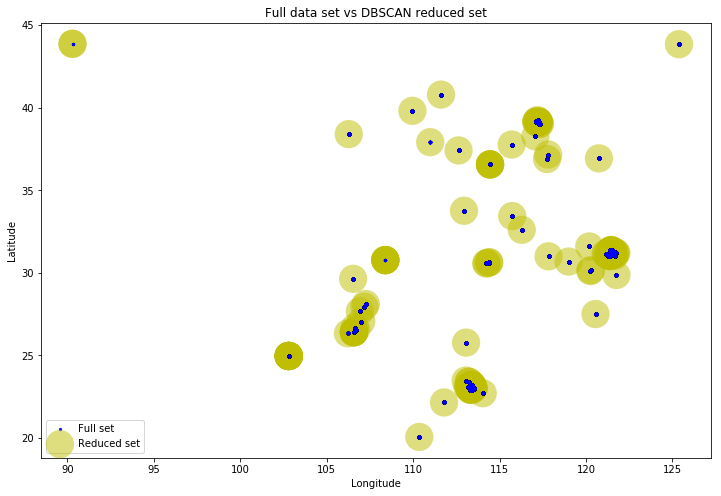

In [38]:
fig, ax = plt.subplots(figsize=[12, 8])
rs_scatter = ax.scatter(rs['LON84'], rs['LAT84'], c='y', edgecolor='None', alpha=0.5, s=800)
df_scatter = ax.scatter(df['LON84'], df['LAT84'], c='b', alpha=0.9, s=5) # full dataset
ax.set_title('Full data set vs DBSCAN reduced set')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='best')
plt.show()

## Get actual address and group by city

In [39]:
# get coordinates of charged location for each row
charge_locations = pd.merge(df[['CCS_CHARGEVOLT', 'CCS_CHARGECUR', 'cluster']], 
                            rs[['LON84', 'LAT84', 'cluster']], how='left', on='cluster')
# energy is in unit of kWh
charge_locations['energy'] = charge_locations['CCS_CHARGEVOLT'] * charge_locations['CCS_CHARGECUR'] * 10 / 3600 / 1000
charge_locations = charge_locations[['LAT84', 'LON84', 'energy']]
charge_locations.head()

,LAT84,LON84,energy
0,23.043836,113.49245,0.005475
1,23.043836,113.49245,0.005468
2,23.043836,113.49245,0.005479
3,23.043836,113.49245,0.005478
4,23.043836,113.49245,0.005476


In [40]:
# Group by charging station (range of 10 meters)
charged_energy_by_station = charge_locations.groupby(['LAT84', 'LON84'], as_index=False)['energy'].sum().\
                            sort_values(by='energy', ascending=False).reset_index(drop=True)
charged_energy_by_station.head()

,LAT84,LON84,energy
0,23.041527,113.493241,18.523059
1,30.622575,114.409208,12.834338
2,31.309605,121.531502,11.253777
3,24.966002,102.804877,10.922323
4,36.566150,114.450161,10.416922


In [41]:
# API key for Gaode found here: https://github.com/DenisCarriere/geocoder/blob/master/tests/test_gaode.py
# default quota is 2000 times/day
def rev_geocode((lat, lon)):
    g = geocoder.gaode([lat, lon], method='reverse', key='0716e5809437f14e3dd0793a5c6d2b13')
    while not g.ok:
        print('retrying..')
        time.sleep(5)
        g = geocoder.gaode([lat, lon], method='reverse', key='0716e5809437f14e3dd0793a5c6d2b13')
    res = [g.housenumber, g.street, g.district, g.city, g.state, g.country, g.adcode, g.address]
    return pd.Series(res)

In [43]:
dest_file = 'CEBS_{}.csv'.format(d)
if os.path.exists(dest_file):
    charged_energy_by_station = pd.read_csv(dest_file)
else:
    fields = ['number', 'street', 'district', 'city', 'province', 'country', 'zipcode', 'address']
    %time charged_energy_by_station[fields] = \
        charged_energy_by_station[['LAT84', 'LON84']].apply(rev_geocode, axis=1)
    charged_energy_by_station.to_csv(dest_file, encoding='utf-8', index=False)

In [44]:
charged_energy_by_station.head()

,LAT84,LON84,energy,number,street,district,city,province,country,zipcode,address
0,31.236300,121.257883,26.008773,52号,纪邹路,闵行区,上海市,上海市,中国,310112,上海市闵行区华漕镇纪邹路52号
1,27.023791,106.028900,19.596938,541-6号,清毕路,黔西县,毕节市,贵州省,中国,520522,贵州省毕节市黔西县杜鹃街道清毕路541-6号
2,23.385780,113.189741,17.406058,2号,中新大路,花都区,广州市,广东省,中国,440114,广东省广州市花都区新华街道广州百亚照明电气不锈钢工程部
3,39.202277,117.128594,15.777531,126号,辰旺路,北辰区,天津市,天津市,中国,120113,天津市北辰区天穆镇辰兴路
4,36.202525,113.116694,15.334080,47号,英雄中路,城区,长治市,山西省,中国,140402,山西省长治市城区太行西街街道财政局家属院(太西一巷)太行公园


In [45]:
# Group by city/district/zipcode
groupby_cols = ['district', 'province', 'city']
charged_energy_by_station.groupby(groupby_cols)['energy'].sum().sort_values(ascending=False)

district  province  city       
浦东新区      上海市       上海市            341.616435
闵行区       上海市       上海市            208.523961
[]        广东省       中山市            202.961573
番禺区       广东省       广州市            119.549591
宝山区       上海市       上海市            111.661275
白云区       广东省       广州市             95.754260
嘉定区       上海市       上海市             68.619998
海珠区       广东省       广州市             63.774488
北辰区       天津市       天津市             55.226902
普陀区       上海市       上海市             51.589744
天河区       广东省       广州市             49.722924
西青区       天津市       天津市             43.328907
高青县       山东省       淄博市             43.206149
杨浦区       上海市       上海市             42.838468
花都区       广东省       广州市             42.823476
荔湾区       广东省       广州市             38.982627
洪山区       湖北省       武汉市             38.916625
[]        广东省       东莞市             37.861916
河东区       天津市       天津市             35.629844
龙华区       广东省       深圳市             34.145969
津南区       天津市       天津市             33.834537
黔西

## Visualize on map

In [48]:
charged_energy_by_stationergy_by_station_energy_by_station.to_csv('charged_energy_by_station.csv', index=False)

In [46]:
charged_energy_by_station.head()

,LAT84,LON84,energy,number,street,district,city,province,country,zipcode,address
0,31.236300,121.257883,26.008773,52号,纪邹路,闵行区,上海市,上海市,中国,310112,上海市闵行区华漕镇纪邹路52号
1,27.023791,106.028900,19.596938,541-6号,清毕路,黔西县,毕节市,贵州省,中国,520522,贵州省毕节市黔西县杜鹃街道清毕路541-6号
2,23.385780,113.189741,17.406058,2号,中新大路,花都区,广州市,广东省,中国,440114,广东省广州市花都区新华街道广州百亚照明电气不锈钢工程部
3,39.202277,117.128594,15.777531,126号,辰旺路,北辰区,天津市,天津市,中国,120113,天津市北辰区天穆镇辰兴路
4,36.202525,113.116694,15.334080,47号,英雄中路,城区,长治市,山西省,中国,140402,山西省长治市城区太行西街街道财政局家属院(太西一巷)太行公园


In [70]:
%%time
m = folium.Map(
    location=[33.8530, 109.5632], 
    zoom_start=4.3, 
#     tiles='Mapbox Bright',
#     width=1200,
#     height=800,
)
N = charged_energy_by_station.shape[0]
for i in range(N):
    lat = charged_energy_by_station['LAT84'].iloc[i]
    lon = charged_energy_by_station['LON84'].iloc[i]
    energy = charged_energy_by_station['energy'].iloc[i]
    message = 'Lat: {:.6f}, Lon: {:.6f}, Consumed Energy: {:.2f} kWh'.format(lat, lon, energy)
#     folium.CircleMarker([lat, lon], radius=2).add_to(m)
#     folium.Marker()
    folium.Circle([lat, lon]).add_to(m)
m.save('mymap.html')

CPU times: user 21.3 s, sys: 59.1 ms, total: 21.4 s
Wall time: 21.3 s


In [2]:
import pandas as pd

In [3]:
d = 20150803
header, configs = load_header_config('aglog_header.csv')
df = pd.read_csv('ag_{}.csv'.format(d), header=None, names=header, index_col=False)
print(df.shape)
df.dropna(subset=['LAT84', 'LON84'], inplace=True)
print(df.shape)
df = df[(df['CCS_CHARGECUR'].isna()) | (df['CCS_CHARGECUR'] < 0.1)]
print(df.shape)

df['TDATE'] = pd.to_datetime(df['TDATE'], unit='ms', utc=True).dt.tz_convert('Asia/Hong_Kong')
df.sort_values(by=['VIN', 'TDATE'], inplace=True)

# drop time duplicate
df['TDELTA'] = df['TDATE'].diff().fillna(timedelta(seconds=10))
df['TDELTA'] = df['TDELTA'].apply(lambda x: x.seconds)
df = df[df['TDELTA'] > 5]
print(df.shape)

# drop LON and LAT duplicate
df.drop_duplicates(subset=['LAT84', 'LON84'], inplace=True)
print(df.shape)

df.reset_index(drop=True, inplace=True)

(755595, 85)
(712569, 85)
(571605, 85)
(567747, 86)
(524186, 86)


In [4]:
vins = df['VIN'].unique()
len(vins)

270

In [5]:
vin = 'LMGGN1S5XE1000260'

df_single = df[df['VIN'] == vin]

df_single.shape

(498, 86)

In [6]:
df_single.head()

,VIN,TDATE,SDATE,BMS_BATTST,BMS_BATTCURR,BMS_BATTVOLT,BMS_INSULATIONST,BMS_INSULATIONRES,BMS_CELLVOLTMAX,BMS_CELLVOLTMIN,BMS_FAILURELVL,BMS_BATTSOC,BMS_BATTTEMPAVG,BMS_BATTTEMPMAX,BMS_BATTTEMPMIN,CCS_CHARGEVOLT,CCS_CHARGECUR,CCS_CHARGERSTARTST,VCU_SYSFAILMODE,MCU_FTM_ACTROTSPD,MCU_FTM_ACTTORQ,MCU_FTM_STMODE,MCU_FTM_MOTORACTTEMP,MCU_FTM_ROTORACTTEMP,MCU_FTM_INVERTERACTTEMP,MCU_FTM_ACTHV_CUR,MCU_FTM_ACTHV_VOLT,MCU_FTM_FAULT_INFO1,MCU_FTM_FAULT_INFO2,MCU_DCDC_FAILST,MCU_DCDC_STMODE,VCU_DCDC_STMODELREQ,BMS_BAT_ERROR_SOC_L,BMS_BAT_ERROR_CELL_V_H,BMS_BAT_ERROR_CELL_V_L,BMS_BAT_ERROR_PACK_SUMV_H,BMS_BAT_ERROR_PACK_SUMV_L,BMS_BAT_ERROR_CELL_T_H,BMS_BAT_ERROR_T_UNBALANCE,MCU_GM_FAILST,MCU_FTM_FAILST,MCU_FTM_FAULT_INFO3,MCU_GM_ACTROTSPD,MCU_GM_ACTTORQ,MCU_GM_STMODE,MCU_GM_MOTORACTTEMP,MCU_GM_ROTORACTTEMP,MCU_GM_INVERTERACTTEMP,MCU_GM_ACTHV_CUR,MCU_GM_ACTHV_VOL,EMS_ENGTORQ,EMS_ENGSPD,EMS_ACCPEDALPST,EMS_BRAKEPEDALST,EMS_ENGWATERTEMP,HCU_GEARFORDSP,HCU_OILPRESSUREWARN,HCU_AVGFUELCONSUMP,HCU_BATCHRGDSP,BCS_VEHSPD,ICM_TOTALODOMETER,BCM_KEYST,HCU_DSTOIL,HCU_DSTBAT,EMS_FAULTRANKSIG,SRS_CRASHOUTPUTST,SRS_DRIVERSEATBELTST,EDC_STERRLVLCOM,EDC_STERRLVLCOMSUP,EDB_STERRLVLHVES,EDG_STERRLVLGEN,EDM_STERRLVLMOT,EDE_STERRLVLENG,EDV_STERRLVLVEH,LON84,LAT84,LON02,LAT02,BCS_ABSFAULTST,BCS_EBDFAULTST,MCU_DCDC_ACTTEMP,BMS_HVILST,HCU_HEVSYSREADYST,BMS_BALANCEST,GPS_HEADING,TDELTA
482610,LMGGN1S5XE1000260,2015-08-03 07:38:10+08:00,20150803,4.0,2.5,338.0,0.0,1022.0,3.26,3.25,0.0,27.7,30.5,31.0,30.0,NaN,NaN,NaN,0.0,0.0,-0.5,4.0,38.0,33.0,29.0,-2.0,336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1282.0,-10.0,8.0,38.0,33.0,34.0,-2.0,337.0,21.560,1269.0,0.000,1.0,30.0,15.0,1.0,19.9,0.0,0.00000,6026.0,2.0,110.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.31102,22.960543,113.31641,22.957851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51734
482611,LMGGN1S5XE1000260,2015-08-03 07:38:20+08:00,20150803,4.0,5.0,337.0,0.0,1022.0,3.25,3.24,0.0,27.7,30.5,31.0,30.0,NaN,NaN,NaN,0.0,0.0,-0.5,4.0,36.0,31.0,29.0,1.0,336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1325.0,-3.0,8.0,37.0,32.0,34.0,1.0,338.0,20.384,1319.0,0.000,1.0,30.0,15.0,1.0,19.9,0.0,0.00000,6026.0,2.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.31111,22.960600,113.31650,22.957910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
482612,LMGGN1S5XE1000260,2015-08-03 07:38:30+08:00,20150803,4.0,16.0,335.0,0.0,1022.0,3.24,3.23,0.0,27.5,30.5,31.0,30.0,NaN,NaN,NaN,0.0,1822.0,17.5,8.0,36.0,31.0,39.0,14.0,334.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1296.0,-4.0,8.0,38.0,33.0,34.0,12.0,335.0,20.384,1287.0,10.192,0.0,33.0,12.0,1.0,19.9,0.0,23.85000,6026.0,2.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.31136,22.960423,113.31675,22.957735,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
482613,LMGGN1S5XE1000260,2015-08-03 07:38:43+08:00,20150803,4.0,9.0,335.0,0.0,1022.0,3.24,3.23,0.0,27.4,30.5,31.0,30.0,NaN,NaN,NaN,0.0,2197.0,16.5,8.0,37.0,32.0,35.0,13.0,334.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1249.0,-3.0,8.0,38.0,33.0,35.0,10.0,334.0,19.600,1230.0,3.920,0.0,36.0,12.0,1.0,14.3,0.0,29.36250,6026.0,2.0,110.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.31178,22.959570,113.31717,22.956882,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
482614,LMGGN1S5XE1000260,2015-08-03 07:38:53+08:00,20150803,4.0,-2.5,337.0,0.0,1022.0,3.25,3.24,0.0,27.4,30.5,31.0,30.0,NaN,NaN,NaN,0.0,1755.0,-1.5,8.0,36.0,31.0,36.0,-2.0,336.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1297.0,-8.5,8.0,39.0,34.0,36.0,-2.0,336.0,19.600,1297.0,0.000,0.0,39.0,12.0,1.0,11.8,0.0,22.89375,6026.0,2.0,108.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.31253,22.959316,113.31792,22.956629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10


In [7]:
lats, lons = df_single['LAT84'].tolist(), df_single['LON84'].tolist()    

In [15]:
%%time
m = folium.Map(location=[np.mean(lats), np.mean(lons)], zoom_start=12.5)
for lat, lon in zip(lats, lons):
    folium.CircleMarker([lat, lon], color='blue', fill=True, fill_opacity=0.3, weight=1, radius=5).add_to(m)
folium.Marker([lats[0], lons[0]], popup='trip_start', icon=folium.Icon(color='green', icon='map-marker')).add_to(m)
folium.Marker([lats[-1], lons[-1]], popup='trip_end', icon=folium.Icon(color='red', icon='map-marker')).add_to(m)

# m.save('mymap.html')
display(m)

CPU times: user 4.99 s, sys: 75.7 ms, total: 5.07 s
Wall time: 5.06 s
